In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

import scipy
from scipy.optimize import curve_fit
import tqdm

import helper_scripts
import pandas as pd

In [2]:
filename = '/data/xebra/processed/20180903_1926.hdf5'

In [3]:
data = {
    's1_0' : [],
    's1_1' : [],
    's1_0_aft' : [],
    's1_1_aft' : [],
    's1_dt' : [],
    's1' : [],
    's2' : [],
    'drift_time' : [],
    's2_width' : [],
}

for event in helper_scripts.get_events(filename):
    if not len(event['s1s']) or not len(event['s2s']) or not len(event['interactions']):
        continue
    
    s1_0 = event['s1s'][0]
    
    ia = event['interactions'][0]
    
    s2 = event['peaks'][ia['s2']]
    s1 = event['peaks'][ia['s1']]
    
    data['s1_0'].append(s1_0['area'])
    data['s2'].append(s2['area'])
    data['s1'].append(s1['area'])
    
    data['drift_time'].append(ia['drift_time'])
    
    data['s2_width'].append(s2['range_area_decile'][5])
    data['s1_0_aft'].append(s1_0['area_fraction_top'])
    
    if len(event['s1s']) > 1:
        s1_1 = event['s1s'][1]
        data['s1_1'].append(s1_1['area'])
        data['s1_1_aft'].append(s1_1['area_fraction_top'])
        data['s1_dt'].append(s1_1['center_time']-s1_0['center_time'])
    else:
        data['s1_1'].append(0.1)
        data['s1_1_aft'].append(-1)
        data['s1_dt'].append(-1)
    
data = pd.DataFrame(data)
print('Loaded %i events' % len(data))

100%|██████████| 129797/129797 [04:45<00:00, 455.16it/s]


Loaded 55853 events


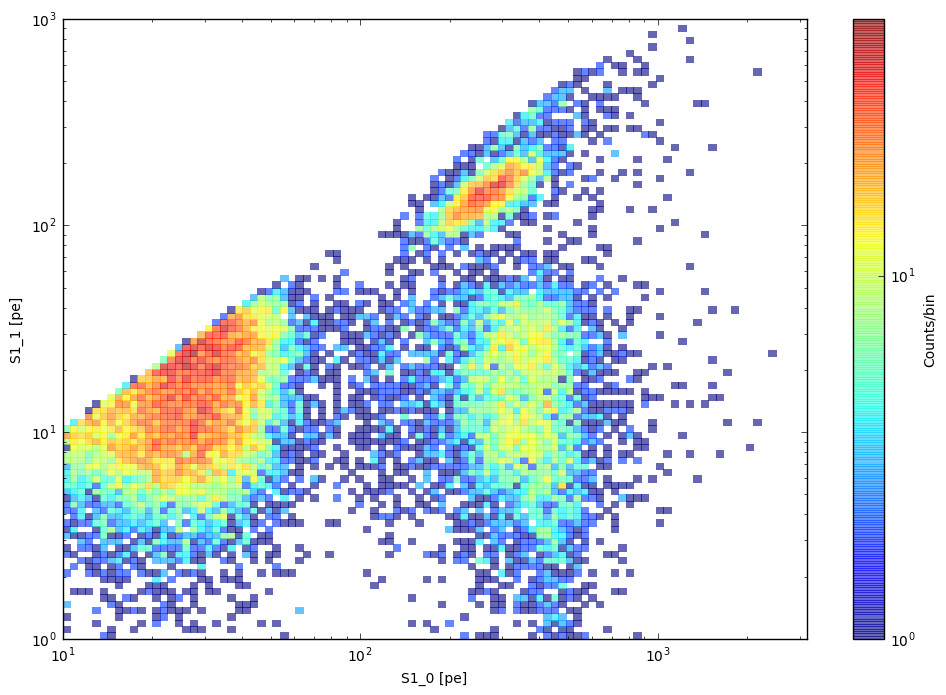

In [9]:
fig, ax = plt.subplots(figsize=(12,8))

here = data
#here = here[(600 < here['s1_dt']) & (here['s1_dt'] < 1500)]
#here = here[(100 < here['s1_0']) & (here['s1_0'] < 1500)]
#here = here[(1 < here['s1_1']) & (here['s1_1'] < 60)]
#print(len(here))
bins_x = np.logspace(1,3.5,100)
bins_y = np.logspace(0,3,100)
counts, _, _ = np.histogram2d(here['s1_0'], here['s1_1'], bins=(bins_x, bins_y))
im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm(),alpha=0.6)

#here = here[(600 < here['s1_dt']) & (here['s1_dt'] < 1500)]
#counts, _, _ = np.histogram2d(here['s1_0'], here['s1_1'], bins=(bins_x, bins_y))
#im1 = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm())
ax.set_xlabel('S1_0 [pe]')
ax.set_ylabel('S1_1 [pe]')
plt.colorbar(im, ax=ax, label='Counts/bin')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(bins_x[0], bins_x[-1])
ax.set_ylim(bins_y[0], bins_y[-1])
plt.show()

1297
('amplitude', 2185.0050098930815, 342.81167671130981)
('half-life', 168.52424335653296, 8.3263139589662742)
('bkg', 1.7968847494573441, 0.46997010515198595)


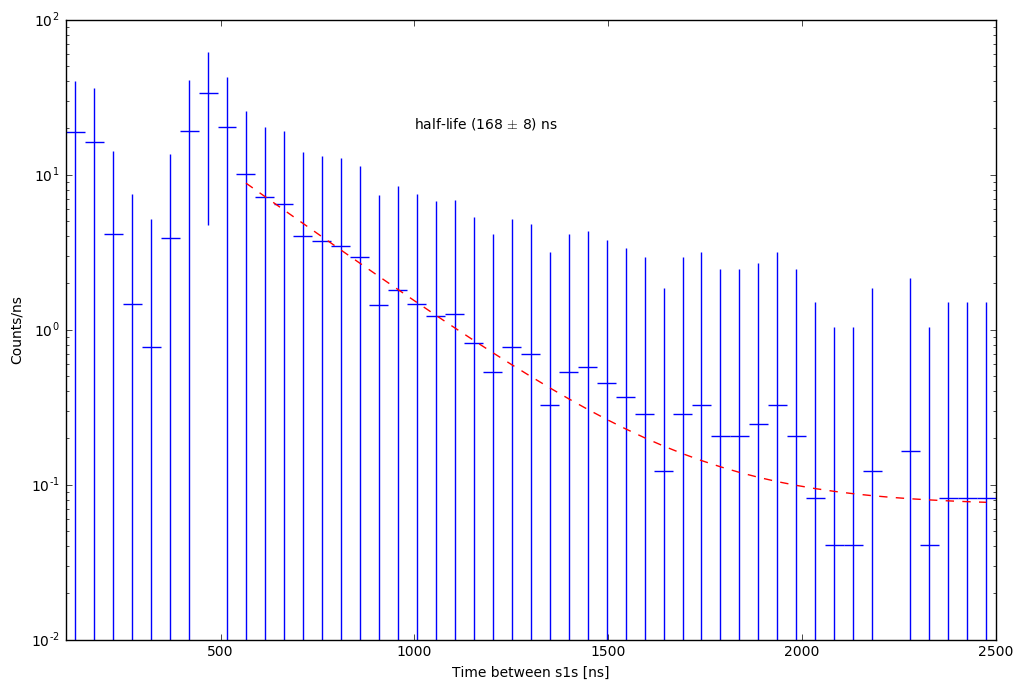

In [5]:
def fit_func(x,amp,hl,bkg):
    return bkg + amp*np.exp(-np.log(2)/hl*x)

fig, ax = plt.subplots(figsize=(12,8))

here = data[data['s1_dt'] > 0]
here = here[here['s1_1'] < 100]

bins = np.linspace(100,2500,50)
bin_centers = 0.5*(bins[1:] + bins[:-1])
bin_widths = 0.5*(bins[1:] - bins[:-1])
n, _ = np.histogram(here['s1_dt'], bins=bins)

plt.errorbar(bin_centers, n/bin_widths, xerr=bin_widths, yerr = np.sqrt(n), capsize=0, linestyle='')

mask = bin_centers > 550
n = n[mask]
print(sum(n))
bin_centers = bin_centers[mask]
bin_widths = bin_widths[mask]
p0 = [800,150,1]
nn = ['amplitude', 'half-life', 'bkg']
popt, pconv = curve_fit(fit_func, bin_centers, n, sigma=np.maximum(np.sqrt(n), np.ones_like(n)), p0=p0)

plt.plot(bin_centers, fit_func(bin_centers, *popt)/bin_widths, linestyle='--',c='r')
plt.annotate(xy=(1000,20),s='half-life (%i $\pm$ %i) ns' % (popt[1], np.sqrt(pconv[1,1])))
for a in zip(nn,popt,np.sqrt(np.diag(pconv))):
    print(a)
    
ax.set_yscale('log')
ax.set_xlabel('Time between s1s [ns]')
ax.set_ylabel('Counts/ns')
ax.set_xlim(bins[0], bins[-1])
#ax.set_ylim(0.8,200)
plt.show()


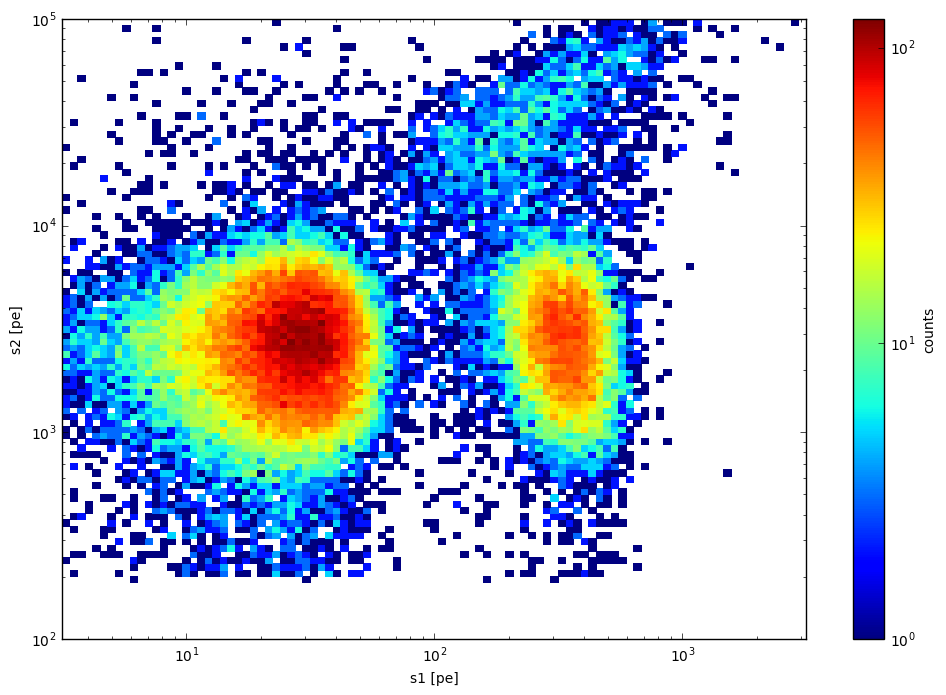

In [6]:
fig, ax = plt.subplots(figsize=(12,8))

here = data
#here = here[(550 < here['s1_dt']) & (here['s1_dt'] < 1500)]
#here = here[here['s1_0'] < 100]

counts, bins_x, bins_y = np.histogram2d(here['s1'],here['s2'], bins=(np.logspace(0.5,3.5,100),np.logspace(2,5,100)))
im = ax.pcolormesh(bins_x, bins_y, counts.T,norm=LogNorm())

plt.colorbar(im,ax=ax,label='counts')

#lower_line = np.array([[300,1500],
#                       [600,0]])
#upper_line = np.array([[300,3500],
#                       [1000,0]])
#plt.plot(lower_line[:,0], lower_line[:,1],c='r',linewidth=3)
#plt.plot(upper_line[:,0], upper_line[:,1],c='r',linewidth=3)

ax.set_xlabel('s1 [pe]')
ax.set_ylabel('s2 [pe]')
ax.set_ylim(bins_y[0], bins_y[-1])
ax.set_xlim(bins_x[0], bins_x[-1])
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()


Using 12060 events
('Amplitude', 4051.3738702631667, 166.89652326337281)
('Livetime', 62.647736276687638, 9.4009412298288417)


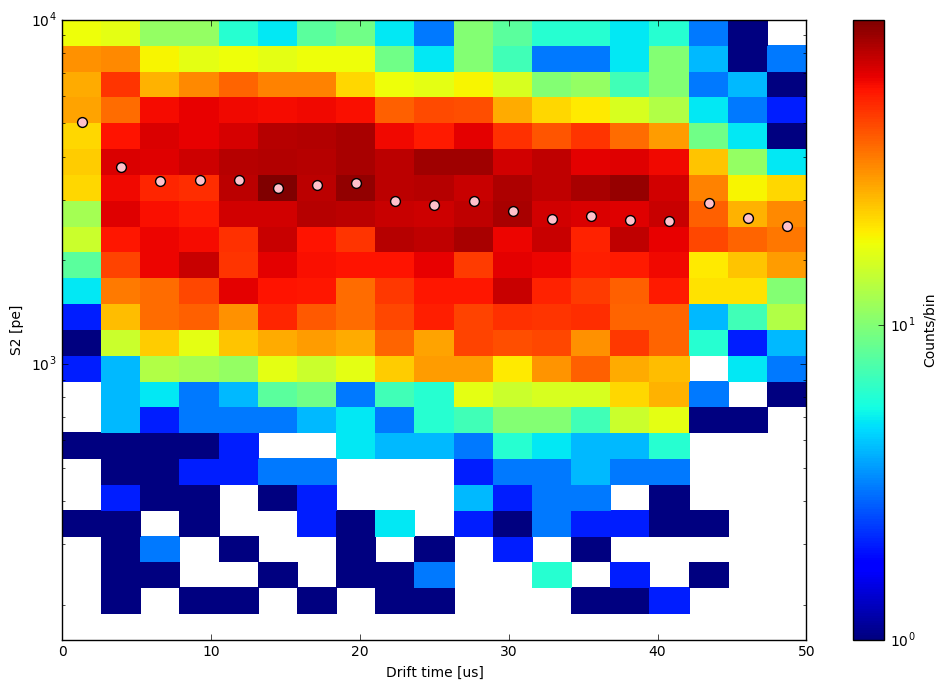

In [11]:
here = data
here = here[here['s1'] > 200]
here = here[here['s1'] < 800]
here = here[here['s2'] < 1e4]


print('Using %i events' % len(here))

fig, ax = plt.subplots(figsize=(12,8))

bins_x = np.linspace(0,50,20)
bins_y = np.logspace(2.2,4,25)

counts, _, _ = np.histogram2d(here['drift_time']/1000, here['s2'], bins=(bins_x,bins_y))
im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm())

plt.colorbar(im, ax=ax, label='Counts/bin')
ax.set_yscale('log')

ax.set_ylabel('S2 [pe]')
ax.set_xlabel('Drift time [us]')

ax.set_xlim(bins_x[0], bins_x[-1])
ax.set_ylim(bins_y[0], bins_y[-1])

bin_centers_x = 0.5*(bins_x[1:] + bins_x[:-1])
bin_centers_y = 0.5*(bins_y[1:] + bins_y[:-1])

avg = np.average(np.meshgrid(bin_centers_x, bin_centers_y)[1], axis=0, weights=counts.T)

ax.scatter(bin_centers_x, avg, s=50,c='pink')

def fit_func(x,amp,lt):
    return amp*np.exp(-np.log(2)/lt*x)

popt, pconv = curve_fit(fit_func, bin_centers_x, avg, p0=[4000,60])
nn = ['Amplitude', 'Livetime','Bkg']
for a in zip(nn,popt,np.sqrt(np.diag(pconv))):
    print(a)

plt.show()